In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import scipy
import scipy.spatial
import numpy as np
import math
import random
import statistics
import logging
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)
logging.info("Loaded")

# targeted time in seconds
SEQUENCE_TIME = 5.0
# minimum time of path to be used (in seconds)
MIN_SEQUENCE_TIME = 2 * SEQUENCE_TIME

# x,y in mm, 1000x is 1m, this should be roughly the largest distance a person might travel in the given timeframe
SCALING_FACTOR = 10000

# size of the goal relative to the scaling factor
# increase this above 1 to allow goals further away then the grid
# TODO does goal size make sense? grid does not support this as of yet, neither does the visualization
GOAL_SIZE = 1

## Sequence slicing parameters
# number of frames each second
FRAME_FREQUENCY = 10
# number of input frames
# ms per frame * seconds
INPUT_FRAME_NUMBER = FRAME_FREQUENCY * 4
# number of output frames
OUTPUT_FRAME_NUMBER = FRAME_FREQUENCY * 4
# offset from y horizon that should be used as goal point
# TODO right now goal is always 3 seconds behind the horizon, make this random
GOAL_FRAME_OFFSET = FRAME_FREQUENCY * 3

## Data Augmentation parameters
# number of frames between window slices
WINDOW_SLICING_DISTANCE = 4
# amount of additional paths generated by rotation
ROTATION_AMOUNT = 5

INFO:root:Loaded


In [2]:
def draw_complete_path(frame, name):
    x_vals = frame.x.to_list()
    y_vals = frame.y.to_list()
    
    plt.title(name)
    plt.plot(x_vals, y_vals)
    plt.show()

def draw_input_path(x, y, goal_pos, goal_index):
    """
    Draws input data.
    x = 
    """
    xvals_of_x = x[:,0]
    yvals_of_x = x[:,1]
    xvals_of_y = y[:,0]
    yvals_of_y = y[:,1]

    current_x = xvals_of_x[-1]
    current_y = yvals_of_x[-1]

    fig, ax = plt.subplots()
    fig.set_size_inches(8.0, 8.0)
    ax.set_xticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    ax.set_yticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    # draw the goal pos
    goal_index_x, goal_index_y = _goal_index_to_xy_indices(goal_index)
    scaling_factor = 0.4
    print(goal_index_x, goal_index_y)
    rect = patches.Rectangle((goal_index_x*scaling_factor - 1, -goal_index_y*scaling_factor + 0.6), 0.4, 0.4, facecolor='lightgray')
    ax.add_patch(rect)
    
    
    # ax.text(goal_index_x*scaling_factor, goal_index_y*scaling_factor, goal_index, transform=ax.transAxes)

    # draw past path
    ax.plot(xvals_of_x, yvals_of_x, 'b')
    # draw future path
    ax.plot(xvals_of_y, yvals_of_y, 'r')
    # draw current position point
    ax.plot(current_x, current_y, 'bo')
    # draw goal point
    ax.plot(goal_pos[0], goal_pos[1], 'ro')

    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.show()

def _get_goal_index(position):
    """
    Gets goal grid coordinates for 5x5 goal.
    """
    x, y = position

    col = 0
    gx = abs(x) / GOAL_SIZE
    if gx > 0.6:
        col = 2
    elif gx > 0.2:
        col = 1
    else:
        col = 0
    
    # get the correct sign
    col = int(math.copysign(col, x)) + 2
    assert(0 <= col <= 4) 

    row = 0
    gy = abs(y) / GOAL_SIZE
    if gy > 0.6:
        row = 2
    elif gy > 0.2:
        row = 1
    else:
        row = 0
    
    # get the correct sign
    row = -(int(math.copysign(row, y)) - 2)
    assert(0 <= row <= 4)

    return row * 5 + col

def _goal_index_to_xy_indices(goal_index):
    row = int(goal_index // 5)
    col = goal_index % 5
    return col, row

# taken from
# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
def rotate_array(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def generate_sequences(frame):
    """
    Returns a list of people.
    Has the following format: a list of lists of (x, goal, y)
    """

    ids = df.id.unique()
    logging.info("%s unique ids", len(ids))
    logging.info("Loading...")
    
    # contains all people paths
    all_persons_list = []

    # contains the maximum values
    max_vals = []

    skipped_too_short = 0
    skipped_frequency_problem = 0
    gen_total = 0

    # filtered_sequences = []
    for name_id in tqdm(ids):
        # skip low ids, they are not real persons
        if name_id <= 1:
            continue

        # get only the elements relevant to the tracked person
        id_frame = df[df["id"] == name_id]
        # can now change the index to time, now that we observe single person there should
        # no longer be a time conflict
        id_frame = id_frame.set_index("time")
        
        # get sequence time in seconds
        time_length = (id_frame.index.max() - id_frame.index.min()).seconds
        # filter out too short sequences
        if time_length < MIN_SEQUENCE_TIME:
            logging.debug("Skipped too short sequence %s: %ss", name_id, time_length)
            skipped_too_short += 1
            continue

        
        # resample the sequence with variable refresh rate to constant rate
        # 100ms = 10Hz
        id_frame = id_frame.resample("100ms", origin='start', kind='period').first()

        # if tracking data has time-gaps then resampling will generate nan values, skip these sequences
        if id_frame.isnull().values.any():
            logging.debug("Skipped sequence with time-gaps %s", name_id)
            skipped_frequency_problem += 1
            continue

        person_list = []

        # get number of resampled frames
        frame_num = id_frame.shape[0]

        # select only the necessary columns
        id_frame = id_frame.loc[:, ['x', 'y']]

        logging.debug("Person %s: %ss, %s frames", name_id, time_length, frame_num)
        # draw_complete_path(id_frame, "{}_complete".format(name_id))

        # use window slicing to go through path
        index = 0
        gen_by_window_slicing = 0
        while True:
            # get indices for getting the right data
            start_index = index
            stop_index = start_index + INPUT_FRAME_NUMBER + OUTPUT_FRAME_NUMBER + GOAL_FRAME_OFFSET

            # stop if you go out of bounds
            if stop_index >= frame_num:
                break

            # get the relevant values and make copies of them, so the original data doesn't change
            data = id_frame.iloc[start_index:stop_index].to_numpy(copy=True)

            # the last position of the input is the current position of the human
            # substract 1 since one is length and this is an index
            current_pose_index = INPUT_FRAME_NUMBER -1
            current_pos = data[current_pose_index].copy()

            # make the values relative to the position
            data -= current_pos
            assert(data[current_pose_index,0] == 0 and data[current_pose_index,1] == 0)

            # create number of paths equal to the rotation amount, data augmentation
            for _ in range(ROTATION_AMOUNT):
                rotation_angle = random.randrange(0, 359)

                # rotate the data array around the current position (0, 0)
                rotated_data = rotate_array(data.copy(), degrees=rotation_angle)

                # start index of the y position
                y_index = INPUT_FRAME_NUMBER
                # end of the y values
                end_index = y_index + OUTPUT_FRAME_NUMBER

                # (time_steps_input, 2) matrix
                x = rotated_data[:y_index]
                # (time_steps_output, 2) matrix
                y = rotated_data[y_index:end_index]
                # length 2 vector used to convert into one-hot
                goal_pos = rotated_data[-1]
                assert(x[-1,0] == 0 and x[-1,1] == 0)

                # get the highest absolute value within that path
                max_val = max(abs(max(x.min(), x.max(), key=abs)), abs(max(y.min(), y.max(), key=abs)))
                max_vals.append(max_val)
                assert max_val <= 2.0, "Maximum value is {}".format(max_val)

                goal_index = _get_goal_index(goal_pos)
                # draw_input_path(x, y, goal_pos, goal_index)    

                # goal index for 5x5
                goal_one_hot = np.zeros(25, dtype=np.float32)
                goal_one_hot[goal_index] = 1.0
                # print(goal_one_hot)

                # save generated x, goal, y
                person_list.append( (x, goal_one_hot, y) )
                gen_total += 1
                # break

            index += WINDOW_SLICING_DISTANCE
            gen_by_window_slicing += 1
            
            # if len(x_list) > 2:
            #     break
            
            # break
        
        if person_list:
            all_persons_list.append(person_list)
            logging.debug("Generated %s sequences multiplied by factor %s from slicing", len(person_list), gen_by_window_slicing)
        else:
            logging.debug("Empty person list generated")
        
        # break
        # if len(x_list) > 10:
        #     break
    
    logging.info("Generated %s sequences total from %s trajectories.", gen_total, len(all_persons_list))
    logging.info("Skipped %s trajectories. %s too short. %s frequency issue (like gaps).",
        skipped_too_short + skipped_frequency_problem, skipped_too_short, skipped_frequency_problem)
    
    return all_persons_list, max_vals


In [3]:
def _format_x_y(persons):
    x_poses = []
    goals_list = []
    y_poses = []

    # go through all the people
    for person in persons:
        person_x_poses = [i[0] for i in person]
        person_goals   = [i[1] for i in person]
        person_y_poses = [i[2] for i in person]

        x_poses.extend(person_x_poses)
        goals_list.extend(person_goals)
        y_poses.extend(person_y_poses)

    x = np.array(x_poses)
    y = np.array(y_poses)
    goals = np.array(goals_list)
    
    return x, goals, y


def divide_and_format(persons, train_ratio=0.7, eval_ratio=0.2):
    assert(train_ratio + eval_ratio <= 1.0)

    # divide human paths into train, eval and test
    # by dividing them based on humans it is guaranteed that there is no
    # information leak

    # shuffle the paths
    random.shuffle(persons)

    # calculate indices
    num_person = len(persons)
    train_num = int(num_person * train_ratio)
    eval_num = 0
    test_num = 0
    if train_ratio + eval_ratio < 1:
        eval_num = int(num_person * eval_ratio)
        test_num = num_person - (train_num + eval_num)
    else:
        eval_num = num_person - train_num
    
    assert test_num >= 0

    print("Dividing {} human trajectories: {} training, {} eval, {} test".format(num_person, train_num, eval_num, test_num))

    train_data = persons[:train_num]
    eval_data = persons[train_num:train_num+eval_num]
    test_data = None
    if test_num > 0:
        test_data = persons[train_num+eval_num:]
    
    assert(train_num == len(train_data))
    assert(eval_num == len(eval_data))
    assert(test_data is None or test_num == len(test_data))

    train_data = _format_x_y(train_data)
    print("train", train_data[0].shape, train_data[0].dtype, train_data[1].shape, train_data[1].dtype, train_data[2].shape, train_data[2].dtype)
    eval_data = _format_x_y(eval_data)
    print("eval", eval_data[0].shape, eval_data[0].dtype, eval_data[1].shape, eval_data[1].dtype, eval_data[2].shape, eval_data[2].dtype)

    # load test data if available
    if test_data is not None:
        test_data = _format_x_y(test_data)
        print("test", test_data[0].shape, test_data[0].dtype, test_data[1].shape, test_data[1].dtype, test_data[2].shape, test_data[2].dtype)
    
    return train_data, eval_data, test_data
    

def concatenate_x_goal(x, goal):
    """
    Cobines x and goal into a (batch, time, 2 + goal_cells) matrix.
    """

    # repeat goal one-hot-vectors for each frame
    goal_ext = np.repeat(goal, INPUT_FRAME_NUMBER, axis=0).reshape(goal.shape[0], INPUT_FRAME_NUMBER, goal.shape[1])
    assert((goal[0] == goal_ext[0, 0]).all())
    assert((goal[0] == goal_ext[0, -1]).all())
    assert((goal[1] == goal_ext[1, 0]).all())
    assert((goal[1] == goal_ext[1, -1]).all())

    # combine both matrices together
    x_combined = np.concatenate( (x, goal_ext), axis=2)
    assert((x[0,0] == x_combined[0,0,0:2]).all())
    return x_combined


def concatenate_x_goal_batch(x, goal):
    """
    Cobines single x and goal batch into a (time, 2 + goal_cells) matrix.
    """
    assert x.shape == (INPUT_FRAME_NUMBER, 2)
    assert goal.shape == (25,)

    # repeat goal one-hot vector for length of input sequence
    goal_ext = np.expand_dims(goal, axis=0)
    goal_ext = np.repeat(goal_ext, x.shape[0], axis=0)

    x_combined = np.concatenate( (x, goal_ext), axis=1 )
    return x_combined

In [5]:
MAX_EPOCHS = 20

from tensorflow.keras import layers

# TODO also implement FDE
def mean_euclidean_distance(ground_truth, prediction):
    # print(ground_truth.shape, prediction.shape, ground_truth.shape[0], prediction.shape[0])
    batches = prediction.shape[0]
    prediction_length = prediction.shape[1]
    errors = []
    for b in range(batches):
        for t in range(prediction_length):
            error = scipy.spatial.distance.euclidean(ground_truth[b,t], prediction[b,t])
            errors.append(error)
    return statistics.mean(errors)


# TODO perhaps rewrite this to custom metrics class
def calculate_final_metrics(model, eval_x, eval_y):
    """
    Calculates metrics for the entire dataset.
    """
    predictions = model(eval_x)
    distance = mean_euclidean_distance(eval_y, predictions)
    print(f"MED: {distance}")


def compile_and_fit(model, train_x, train_y, eval_x, eval_y, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
                # metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(x=train_x, y=train_y, epochs=MAX_EPOCHS,
                        shuffle=True,
                        validation_data=(eval_x, eval_y),
                        callbacks=[early_stopping])
    return history


def predict_once(model, x, goal=None):
    """
    Makes single prediction using the model.

    Inputs:
        model - trained model
        x - input values of shape (time-steps, features)
            if model requires goal then x should either already be concatenated or goal must be given
        goal - will concatenate the goal to the x values before predicting
    
    Returns (time-steps, 2) matrix, consisting of the x/y positions.
    """
    if model is None or x is None:
        return None
    
    x_input = x

    # combine the goal information into the input positions
    if goal is not None:
        x_input = concatenate_x_goal_batch(x, goal)

    # add batch dimension
    x_input = np.expand_dims(x_input, axis=0)
    
    prediction = model(x_input)[0]
    return prediction


def draw_path(x, ground_truth, goal=None, prediction_model=None, name=None, min_goal_percent = 0.1):
    # seperate the x/y coordinates of input and ground_truth
    x_xvals = x[:,0]
    x_yvals = x[:,1]
    gt_xvals = ground_truth[:,0]
    gt_yvals = ground_truth[:,1]

    # position robot is currently in
    current_x = x_xvals[-1]
    current_y = x_yvals[-1]

    # create the figure
    fig, ax = plt.subplots()
    fig.set_size_inches(8.0, 8.0)

    # if goal is given then draw that
    if goal is not None:
        # get indices in descending order of value
        indices = np.flip(goal.argsort())

        scaling_factor = 0.4
        # iterate through the indices, stop when the values become too low
        for i in indices:
            val = goal[i]
            assert val <= 1.0 and val >= 0

            if val <= min_goal_percent:
                break
            
            goal_index_x, goal_index_y = _goal_index_to_xy_indices(i)
            x_pos = goal_index_x*scaling_factor - 1
            y_pos = -goal_index_y*scaling_factor + 0.6
            color_intensity = 1.0 - val / 3
            color = (color_intensity, color_intensity, color_intensity)
            rect = patches.Rectangle((x_pos, y_pos), scaling_factor, scaling_factor, facecolor=color)

            print(i, goal_index_x, goal_index_y)
            ax.add_patch(rect)

    # generate the goal grid
    ax.set_xticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    ax.set_yticks([-1.0, -0.6, -0.2, 0.2, 0.6, 1.0])
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

    # draw prior path
    ax.plot(x_xvals, x_yvals, 'b')
    # draw ground-truth path
    ax.plot(gt_xvals, gt_yvals, 'r')

    # given the prediction model generate a prediction and draw it
    if prediction_model:
        prediction = predict_once(prediction_model, x, goal=goal)
        # prediction_input = x.reshape(1, x.shape[0], x.shape[1])
        # prediction = prediction_model(prediction_input)[0]
        px = prediction[:,0]
        py = prediction[:,1]
        ax.plot(px, py, 'g')
        # print(prediction)

    # mark current position
    ax.plot(current_x, current_y, 'bo')

    if name is not None:
        plt.title(name)

    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.show()


def draw_path_batch(x, ground_truth, goals=None, prediction_model=None, n=1, skip=0, rnd=False, name="path"):
    """
    Draws multiple predictions.
    Inputs:
        x - (batch, input-time-steps, features) matrix of positions
        ground_truth - (batch, output-time-steps, features) matrix
        goals - (batch, one-hot-vector)
        prediction_model - model to use for predictions
        n - number of plots to generate
        skip - skip this number of batches, makes no sense together with rnd
        rnd - wether the batch should be chosen randomly
        name - what to name the plots
    """
    assert(x.shape[0] == ground_truth.shape[0])

    if skip > 0 and rnd:
        print("WARNING, USED BOTH RANDOM SELECTION AND SKIP FOR DRAWING. IGNORING SKIP")
        skip = 0

    for i in range(n):
        batch_index = i
        if rnd:
            batch_index = random.randrange(0, x.shape[0])
        elif skip > 0:
            batch_index += skip
        
        assert batch_index < x.shape[0], f"Tried to access batch index {batch_index} of {x.shape[0]}"
        
        x_batch = x[batch_index]
        gt_batch = ground_truth[batch_index]
        goal_batch = None

        if goals is not None:
            goal_batch = goals[batch_index]

        plot_name = "{} {}".format(name, batch_index)
        draw_path(x_batch, gt_batch, goal=goal_batch, prediction_model=prediction_model, name=plot_name)


def apply_randomness_to_goal_prediction(goal):
    pass

In [6]:
file_path = "data/small.csv"
# file_path = "data/atc-20121114.csv"

df = pd.read_csv(file_path, names=["time", "id", "x", "y", "z", "velocity", "motion_angle", "facing_angle"])
print(df.head())

# remove unnecessary columns to save memory
df = df.drop(columns=['z', 'velocity', 'motion_angle', 'facing_angle'])
print(df.dtypes)
print(df.head())

# convert time
df['time'] = pd.to_datetime(df['time'], unit='s')
print(df.time.head())

# scale x, y
df['x'] = df['x'] / SCALING_FACTOR
df['y'] = df['y'] / SCALING_FACTOR
print(df.dtypes)

persons, max_vals = generate_sequences(df)
train_data, eval_data, test_data = divide_and_format(persons, train_ratio=0.7, eval_ratio=0.2)

INFO:root:15 unique ids
INFO:root:Loading...
100%|██████████| 15/15 [00:00<00:00, 80.67it/s]
INFO:root:Generated 2535 sequences total from 11 trajectories.
INFO:root:Skipped 4 trajectories. 3 too short. 1 frequency issue (like gaps).


           time       id      x      y         z  velocity  motion_angle  \
0  1.352853e+09  9315400  39830 -22779  1704.245   823.082        -0.499   
1  1.352853e+09  9330400  34873 -17618  1467.723  1280.126         2.821   
2  1.352853e+09  9330600  -9670   7396  1230.397  1095.896         2.322   
3  1.352853e+09  9315400  39848 -22802  1704.947   903.930        -0.648   
4  1.352853e+09  9330400  34830 -17590  1466.868  1302.011         2.751   

   facing_angle  
0        -0.708  
1         2.799  
2         2.357  
3        -0.732  
4         2.748  
time    float64
id        int64
x         int64
y         int64
dtype: object
           time       id      x      y
0  1.352853e+09  9315400  39830 -22779
1  1.352853e+09  9330400  34873 -17618
2  1.352853e+09  9330600  -9670   7396
3  1.352853e+09  9315400  39848 -22802
4  1.352853e+09  9330400  34830 -17590
0   2012-11-14 00:33:08.708000000
1   2012-11-14 00:33:08.708000000
2   2012-11-14 00:33:08.708000000
3   2012-11-14 00:33:

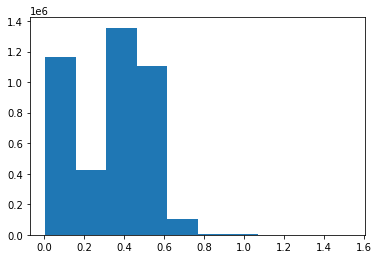

In [6]:
plt.hist(max_vals)
plt.show()

In [7]:
CONV_WIDTH = 3
OUT_STEPS = 40
num_features = 2
LSTM_DEPTH = 128
# model = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
#     tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
#     # Shape => [batch, 1, conv_units]
#     tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
#     # Shape => [batch, 1,  out_steps*features]
#     tf.keras.layers.Dense(OUT_STEPS*num_features,
#                           kernel_initializer=tf.initializers.zeros()),
#     # Shape => [batch, out_steps, features]
#     tf.keras.layers.Reshape([OUT_STEPS, num_features])
# ])

## simple LSTM (no goal)
model = tf.keras.Sequential()
model.add(layers.LSTM(LSTM_DEPTH))
model.add(layers.Dense(OUT_STEPS*num_features))
model.add(layers.Reshape([OUT_STEPS, num_features]))

## train no-goal model
history_model = compile_and_fit(model, train_data[0], train_data[2], eval_data[0], eval_data[2])

Epoch 1/20
56/56 [==============================] - 2s 7ms/step - loss: 0.0147 - mean_absolute_error: 0.0764 - val_loss: 0.0021 - val_mean_absolute_error: 0.0324
Epoch 2/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0465 - val_loss: 0.0018 - val_mean_absolute_error: 0.0304
Epoch 3/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_absolute_error: 0.0463 - val_loss: 0.0024 - val_mean_absolute_error: 0.0356
Epoch 4/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0055 - mean_absolute_error: 0.0441 - val_loss: 0.0031 - val_mean_absolute_error: 0.0392


In [8]:
## simple LSTM (goal)
model_goal = tf.keras.Sequential()
model_goal.add(layers.LSTM(LSTM_DEPTH))
model_goal.add(layers.Dense(OUT_STEPS*num_features))
model_goal.add(layers.Reshape([OUT_STEPS, num_features]))


## train goal model
train_data_goal_x = concatenate_x_goal(train_data[0], train_data[1])
eval_data_goal_x = concatenate_x_goal(eval_data[0], eval_data[1])
history_model_goal = compile_and_fit(model_goal, train_data_goal_x, train_data[2], eval_data_goal_x, eval_data[2])

Epoch 1/20
56/56 [==============================] - 1s 6ms/step - loss: 0.0132 - mean_absolute_error: 0.0757 - val_loss: 0.0030 - val_mean_absolute_error: 0.0420
Epoch 2/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0029 - mean_absolute_error: 0.0374 - val_loss: 0.0020 - val_mean_absolute_error: 0.0337
Epoch 3/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0357 - val_loss: 0.0018 - val_mean_absolute_error: 0.0326
Epoch 4/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_absolute_error: 0.0331 - val_loss: 0.0017 - val_mean_absolute_error: 0.0308
Epoch 5/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0326 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309
Epoch 6/20
56/56 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_absolute_error: 0.0321 - val_loss: 0.0014 - val_mean_absolute_error: 0.0279
Epoch 7/20
56/56 [==========

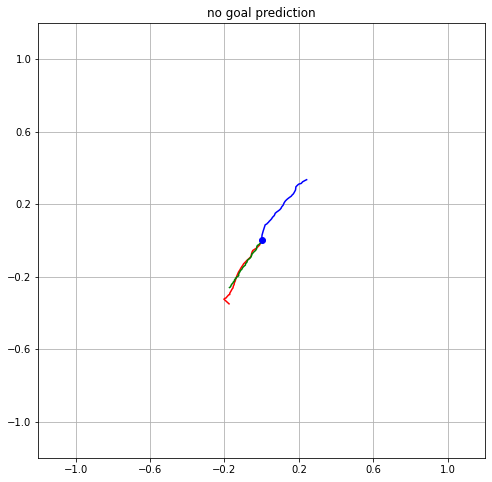

21 1 4


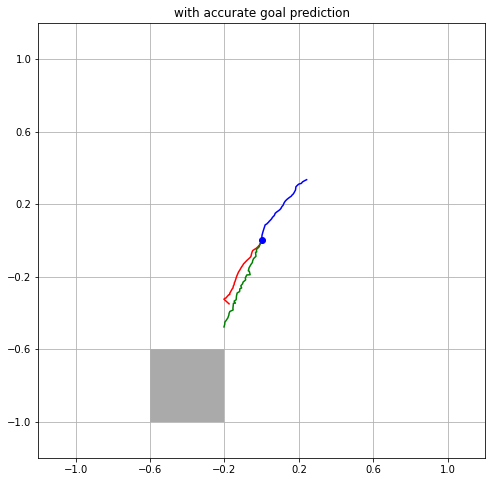

[0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.2 0.  0.  0. ]
4 4 0
21 1 4


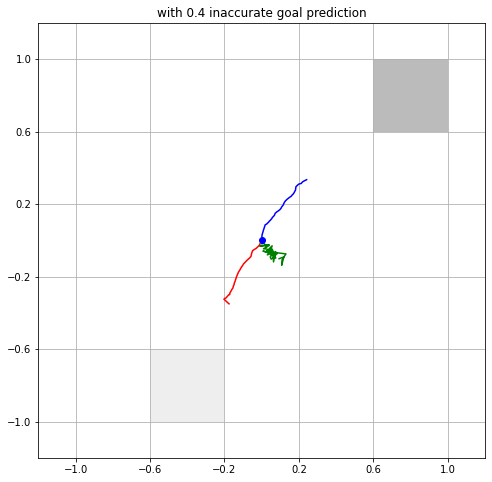

In [12]:
eval_data_x, eval_data_goals, eval_data_y = eval_data

# N = 200
# draw_path_batch(eval_data_x, eval_data_y, n=1, skip=N, goals=eval_data_goals, prediction_model=model, rnd=False, name="no goal")
# draw_path_batch(eval_data_goal_x, eval_data_y, n=1, skip=N, goals=eval_data_goals, prediction_model=model_goal, rnd=False, name="with goal")
# draw_path_batch(eval_data_x, eval_data_y, n=1, skip=N+5, goals=eval_data_goals, prediction_model=model, rnd=False, name="no goal")
# draw_path_batch(eval_data_goal_x, eval_data_y, n=1, skip=N+5, goals=eval_data_goals, prediction_model=model_goal, rnd=False, name="with goal")

N = 0
draw_path(eval_data_x[N], eval_data_y[N], prediction_model=model, name="no goal prediction")
draw_path(eval_data_x[N], eval_data_y[N], eval_data_goals[N], prediction_model=model_goal, name="with accurate goal prediction")

incorrect_goal = eval_data_goals[N].copy()
incorrect_goal[21] = 0.2
incorrect_goal[4] = 0.8
print(incorrect_goal)

draw_path(eval_data_x[N], eval_data_y[N], incorrect_goal, prediction_model=model_goal, name="with 0.4 inaccurate goal prediction")



In [10]:
def test_model(model, test_data):
    """
    Evaluates model with test data.
    """
    x = test_data[0]
    y = test_data[2]
    loss = model.evaluate(x=x, y=y, verbose=True)
    print("Test loss is {}".format(loss))

# test_model(model, test_data)

print("Model no goal:")
calculate_final_metrics(model, eval_data_x, eval_data_y)

print("Model goal")
calculate_final_metrics(model_goal, eval_data_goal_x, eval_data_y)

Model no goal:
(580, 40, 2) (580, 40, 2) 580 580
MED: 0.07984150738876196
Model goal
(580, 40, 2) (580, 40, 2) 580 580
MED: 0.07553843640482974
